In [1]:
#conda activate AP1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import torch
from scipy.stats import skew, kurtosis

#import pyfolio as pf
import empyrical as emp

In [2]:
df = pd.read_excel('data_nn.xlsx')
#df.to_pickle("data_nn.xlsx")

In [3]:
# Set the first column as the date index
df.set_index(df.columns[0], inplace=True)

# Convert the index to string and then to DatetimeIndex format
df.index = pd.to_datetime(df.index.astype(str))

# Filter the data for the last ten years
df_last_10_years = df.loc[df.index > "2013-01-02"]

# Apply rolling sum with a window of 252 and require at least 126 non-NaN values
df_rolling_sum = df_last_10_years.rolling(window=252, min_periods=int(252//2)).sum()

# Forward-fill NaN values, but limit this to a maximum of 5 consecutive fills
df_filled = df_last_10_years.ffill(limit=5)

# Drop any remaining NaN values that still exist after the forward-fill operation
df_cleaned = df_filled.dropna()

#return back original name to not interruppt code.
df_last_10_years = df_cleaned




In [12]:
def refactored_advanced_features(df_returns):
    """
    Refactored computation of advanced financial features to reduce DataFrame fragmentation.
    """
    skew = {}
    kurtosis = {}
    max_drawdown = {}
    volatility = {}
    vaR = {}
    momentum = {}
    avg_return = {}

        
        # 1. Skewness
    print("Skewness")
    for window in [20, 40, 60, 100, 180, 240, 360, 480, 720]:
        skew[window] = df_returns.rolling(window).skew()

        # 2. Kurtosis
    print("Kurtosis")
    for window in [20, 40, 60, 100, 180, 240, 360, 480]:
        kurtosis[window]=df_returns.rolling(window).kurt()
    
    # 3. Maximum drawdown
    print("Maximum drawdown")
    for window in [20, 40, 60, 100, 180, 240, 360, 480]:
        max_drawdown[window] = df_returns.rolling(window).apply(emp.max_drawdown, raw=True)
    
    # 4. Volatility
    print("Volatility")
    for window in [20, 40, 60, 100, 180, 240, 360, 480]:
        volatility[window] = df_returns.rolling(window).std()*(252**0.5)
    
    # 5. Value at Risk
    print("Value at Risk")
    for window in [20, 40, 60, 100, 180, 240, 360, 480]:
        vaR[window] = df_returns.rolling(window).apply(emp.value_at_risk, raw=True)
    
    # 6. Momentum
    print("Momentum")
    for window in [20, 40, 60, 100, 180, 240, 360, 480]:
        momentum[window] = df_returns.rolling(window).sum() # ?

    print("Average Return")
    for window in [20, 40, 60, 100, 180, 240, 360, 480]:
        avg_return[window] = df_returns.rolling(window).mean()

    return skew, kurtosis, max_drawdown, volatility, vaR, momentum, avg_return

# This function reduces DataFrame fragmentation by constructing all columns and concatenating them at once.

# Läs tommys mex hur de gjorde reversal, sen implementera det. Fixa windows size till vad de hade i rapporten.
# skew[20].head() 

In [13]:
advanced_features_df = refactored_advanced_features(df_last_10_years)

Skewness
Kurtosis
Maximum drawdown
Volatility
Value at Risk
Momentum
Average Return


In [18]:
def RSI(df_returns, window):
    """
    Computes the Relative Strength Index (RSI) for a given window.
    """
    df = df_returns.copy()
    df[df >= 0] = 1
    df[df < 0] = 0
    df = df.rolling(window).mean()*100
    return df

In [19]:
rsi = RSI(df_last_10_years, 50)

<AxesSubplot:xlabel='Column1'>

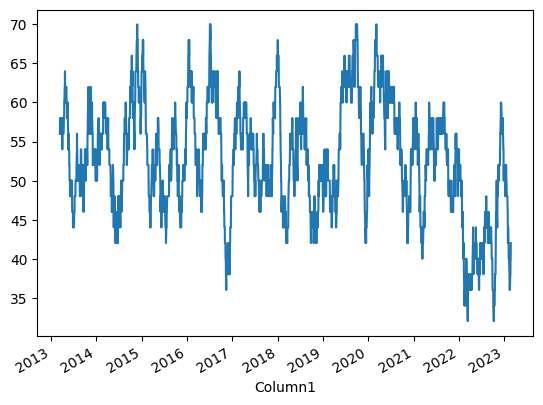

In [16]:
rsi["Bonds_0"].plot()

Benchmark test with returns

In [20]:
import cvxpy as cp

# drop date column
returns = df_last_10_years.drop(columns=df_last_10_years.columns[0])

# Initialize list to store optimal weights and returns for each t
all_weights = []
all_returns = []

# Number of assets
n_assets = len(returns.columns)

# Specified maximum risk level
max_risk = 0.0001

# Larger regularization factor
epsilon = 1e-4

# Start from the 21st observation
for t in range(20, len(returns) - 1):  
    # Data up to time t
    data_t = returns.iloc[:t+1] #masssa missing values?, droppat naans, return.iloc[t-20:t+1], kolla riskbudgetering, more funktionen?
    
    # Calculate mean returns and covariance matrix up to time t
    mean_returns_array = data_t.mean().values
    cov_matrix_values = data_t.cov().values + epsilon * np.eye(n_assets)
    
    # Ensure covariance matrix is symmetric
    cov_matrix_values = (cov_matrix_values + cov_matrix_values.T)/2

    #print(np.linalg.eigvals(np.array(cov_matrix_values)))
    
    # Portfolio weights as a variable
    w = cp.Variable(n_assets) #dubbelkolla W 
    
    # Portfolio risk (variance) using psd_wrap
    portfolio_risk = cp.quad_form(w, cp.psd_wrap(cov_matrix_values))
    
    # Portfolio return
    portfolio_return = mean_returns_array.T @ w
    
    # Constraints
    constraints = [cp.sum(w) == 1, portfolio_risk <= max_risk]
    
    # Formulate the optimization problem
    objective = cp.Maximize(portfolio_return)
    problem = cp.Problem(objective, constraints)
    
    # Solve the problem using ECOS solver
    problem.solve(solver=cp.ECOS)
    print(w.value)
    # Store the optimal weights for time t
    all_weights.append(w.value)
    
    # Calculate and store the portfolio return for time t+1 using weights from time t
    next_return = np.dot(returns.iloc[t+1].values, w.value)
    all_returns.append(next_return)

# Convert lists to arrays for further analysis if needed
all_weights = np.array(all_weights)
all_returns = np.array(all_returns)

# Print the first 5 values of all_returns
#print("First 5 values of all_returns:")
#print(all_returns[:5])



[-0.11092682 -0.0712344  -0.00236744  0.00495279 -0.25805262  0.03258827
 -0.11489064  0.11682958  0.12804097  0.26811652 -0.06463574  0.07175342
 -0.09614298  0.10549822  0.12849897  0.22143864 -0.02921778  0.0922405
  0.08852671  0.12783612 -0.09225135 -0.16935798  0.16120288 -0.18006893
 -0.02361727  0.08183812  0.06134548  0.1516261  -0.13967863  0.0462783
  0.03979653 -0.02122191 -0.02270836 -0.09029849 -0.04684541 -0.04925711
 -0.03091472 -0.05320697  0.0309281   0.02583824  0.03502754 -0.03539968
 -0.00701496  0.00578096  0.05056447  0.09471204  0.28054032  0.06971894
  0.22436704  0.05688314 -0.03674356  0.02377383 -0.00272845 -0.16906495
  0.09130439]
[-0.16880842 -0.1141164  -0.11094793 -0.01240657 -0.27659218 -0.0003114
 -0.12549256  0.09352933  0.13557365  0.28429651 -0.02073264  0.0743299
 -0.16710312  0.1689016   0.09091429  0.2078882   0.00065378  0.10654049
  0.09285639  0.13397628 -0.07298195 -0.16342911  0.13483561 -0.17861924
 -0.00931231  0.08170869  0.04729265  0.1

Risk budgeting

In [8]:
all_weights

[array([ 0.99700269,  1.35270691,  0.69790704,  3.77104213,  1.23427861,
         1.49263756,  2.85787746,  2.28019513,  1.13903963,  1.8247338 ,
         1.72028864,  1.47356615,  0.9259149 ,  5.55931253,  1.61035997,
         1.28004095,  2.08322356,  3.05720366,  2.33066392,  1.49738211,
         4.93766414,  2.71470555,  2.58680732,  5.40123116,  2.12785194,
         3.80986048,  2.03843912,  3.6850125 ,  3.55140079,  5.79292485,
         6.00006868,  9.32269439, 14.84752825,  2.78904347,  7.63142369,
         8.9900147 ,  7.0596721 , 22.84854003,  6.40612844, 24.48203041,
        11.06560936, 29.40702568, 11.2789889 ,  7.69246494,  1.69780854,
         3.10765953,  1.04795187,  1.22170029,  1.71445759,  1.27503815,
         1.59691328,  1.02247468,  1.52387921,  1.89924169,  1.69602256]),
 array([ 1.02033485,  1.37451923,  0.7004274 ,  3.80367655,  1.22855548,
         1.47881016,  2.80109762,  2.18706988,  1.1440283 ,  1.8984354 ,
         1.69456969,  1.44953337,  0.93711668,  5

In [17]:
import cvxpy as cp
from tqdm import tqdm


# Assuming df_last_10_years contains the daily returns
returns = df_last_10_years.drop(columns=df_last_10_years.columns[0])

# Initialize list to store optimal weights and returns for each t
all_weights = []
all_returns = []

# Number of assets
n_assets = len(returns.columns)

# Risk budget for each asset
b = np.ones(n_assets) / n_assets  # For example, equal risk budgeting

# Arbitrary constant for the constraint
c = 1  # Example value, adjust as needed

# Start from the 21st observation
for t in tqdm(range(54,len(returns) - 1,5)):
    # Data up to time t
    data_t = returns.iloc[:t+1].astype("float16")
    print(data_t.index[-1])
    # Covariance matrix of the returns
    cov_matrix_values = data_t.cov().values
    cov_matrix_values = (cov_matrix_values + cov_matrix_values.T)/2

    #cov_matrix_values += np.eye(cov_matrix_values.shape[0],cov_matrix_values.shape[1])

    #if min(eigs) <= 0:
    #    print(t)
    # Portfolio weights as a variable (y)
    y = cp.Variable(shape=n_assets)
    # Objective function: Minimize the square root of the portfolio variance
    objective = cp.Minimize(cp.sqrt(cp.quad_form(y, cp.psd_wrap(cov_matrix_values))))

    # Alternative solutions

    #objective = cp.Minimize(cp.quad_form(y, cp.psd_wrap(cov_matrix_values)))

    #cov_matrix_values = np.array(cov_matrix_values)
    #cov_matrix_values += np.eye(cov_matrix_values.shape[0],cov_matrix_values.shape[1])
    #L = np.linalg.cholesky(cov_matrix_values)
    #objective = cp.Minimize(cp.norm(L@y,2))

    # Constraints:
    # 1. The weights must sum to 1 (full investment)
    # 2. The risk budgeting constraint must be satisfied
    # 3. The weights must be non-negative
    constraints = [
        #cp.sum(y) == 1,        # incompatible with contstraint below. Normalize afterwards
        cp.sum(cp.multiply(b, cp.log(y))) >= c,
        y >= 1e-5 #strict inequalities are not allowed
    ]

    # Formulate the optimization problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem using a suitable solver
    problem.solve(solver=cp.SCS,qcp=True, eps = 1e-5, max_iters  = 100) #kan ange hur många försöja man vill att solve kan göra. Kolla upp det. "Maxiteration". googla på risk budgeting med cvxpy.
    # Store the optimal weights for time t
    optimal_weights = y.value
    #optimal_weights /= np.linalg.norm(optimal_weights,1)
    all_weights.append(optimal_weights)

    #print(optimal_weights)

    #print(type(all_weights))
    #print(type(returns.iloc[t+1].values))
    
    # Calculate and store the portfolio return for time t+1 using weights from time t
    next_return = np.dot(returns.iloc[t+1].values, optimal_weights)
    all_returns.append(next_return)

# Convert lists to arrays for further analysis if needed
#all_weights = np.array(all_weights)
#all_returns = np.array(all_returns)

# Print the first 5 values of all_returns
#print("First 5 values of all_returns:")
#print(all_returns[:5])

2013-03-21 00:00:00


2013-03-28 00:00:00


2013-04-04 00:00:00


2013-04-11 00:00:00


2013-04-18 00:00:00


  1%|          | 4/520 [00:03<06:53,  1.25it/s]


KeyboardInterrupt: 